#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords',quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

# Import Review Data

We have a dataset of roughly 1000 yelp reviews. These reviews are labelled as 0 for having negative sentiment and 1 for having positive sentiment.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/DustinYansberg/Product_Review_Sentiment_Analysis/main/yelp_labelled.csv')
data.head()

,col1,col2,col3,col4,Unnamed: 4,Unnamed: 5
0,Wow... Loved this place.,1,NaN,NaN,NaN,NaN
1,Crust is not good.,0,NaN,NaN,NaN,NaN
2,Not tasty and the texture was just nasty.,0,NaN,NaN,NaN,NaN
3,Stopped by during the late May bank holiday of...,1,NaN,NaN,NaN,NaN
4,The selection on the menu was great and so wer...,1,NaN,NaN,NaN,NaN


# Preprocessing

This dataset needs to be cleaned up a bit. We want to have two columns where the first column is the review in its entirety, and the second column is the 0-1 sentiment rating of the review. However, some reviews are split between multiple columns.

In [4]:
# First, let's replace any instances of the string "nan" as a nan value.
data.replace( "nan", np.nan, inplace=True)

In [5]:
# then let's write a function to merge the reviews into the first column.
def merge_text_and_extract_number(row):
    # Drop NA values
    non_na_values = row.dropna()

    # The last value should be number
    number = non_na_values[-1]

    # All prior values should be text
    text = ' '.join(non_na_values[:-1])

    return pd.Series([text, number])

In [6]:
data = data.apply(merge_text_and_extract_number, axis=1)
data.head()

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Let's see if there are any reviews that are empty. We can do this by sorting the data in ascending order on the first column. I want to first name the columns, so we can identify them more easily than by using generic 0 and 1

In [7]:
data.columns = ['review', 'value']

In [8]:
data.sort_values(by=['review'])

,review,value
602,!....THE OWNERS REALLY REALLY need to quit bei...,0
219,#NAME?,1
26,#NAME?,0
896,#NAME?,0
71,#NAME? really good rice all the time.,1
...,...,...
934,very slow at seating even with reservation.,0
251,very tough and very short on flavor!,0
81,walked in and the place smelled like an old gr...,0
684,will definitely be back!,1


Interesting, there are no empty reviews, but there are some with strange '#NAME?' values, so we want to remove those. Let's write a function that will take care of removing those, and perform some other standard preprocessing functions. The other preprocessing functions we want to do is perform lowercasing, remove punctuation, and remove stopwords.

In [9]:
def clean(comment):
    comment = comment.lower()
    comment = re.sub('#name?', '', comment)
    comment = re.sub('[^a-z A-Z 0-9-]+', '', comment)
    comment = " ".join([word for word in comment.split() if word not in stopwords.words('english')])

    return comment

In [10]:
data['review'] = data['review'].apply(clean)
data = data[data['review'].str.strip() != '']
# since we will be removing entire rows where the values are empty after removing '#name?' we want to make sure we reset the index values to avoid issues while iterating through the reviews in the future.
data = data.reset_index(drop=True)
# index 26 was the first index that had '#name?' as the review, so lets make sure its gone and the index values were reset properly.
data.head(27)

,review,value
0,wow loved place,1
1,crust good,0
2,tasty texture nasty,0
3,stopped late may bank holiday rick steve recom...,1
4,selection menu great prices,1
5,getting angry want damn pho,0
6,honeslty didnt taste fresh,0
7,potatoes like rubber could tell made ahead tim...,0
8,fries great,1
9,great touch,1


# EDA

Let's do some analysis on our dataset to see if we have we can make any assumptions about the data.
We want to answer a few questions:

1. what is the distribution between positive and negative reviews?
2. what are the most common words?
3. what are the most common bigrams and trigrams of positive and negative reviews?
4. what is the distribution of an overall word count?

Let's first create the columns where some info we need to answer those questions will be held.

In [11]:
def return_len(review):
    return len(review)

In [12]:
def word_count(review):
    return len(review.split(' '))

In [13]:
data['sentence_length'] = data['review'].apply(lambda x: return_len(x))

In [14]:
data['word_count'] = data['review'].apply(lambda x: word_count(x))

In [15]:
data.head()

,review,value,sentence_length,word_count
0,wow loved place,1,15,3
1,crust good,0,10,2
2,tasty texture nasty,0,19,3
3,stopped late may bank holiday rick steve recom...,1,61,9
4,selection menu great prices,1,27,4


### Distribution of Dataset

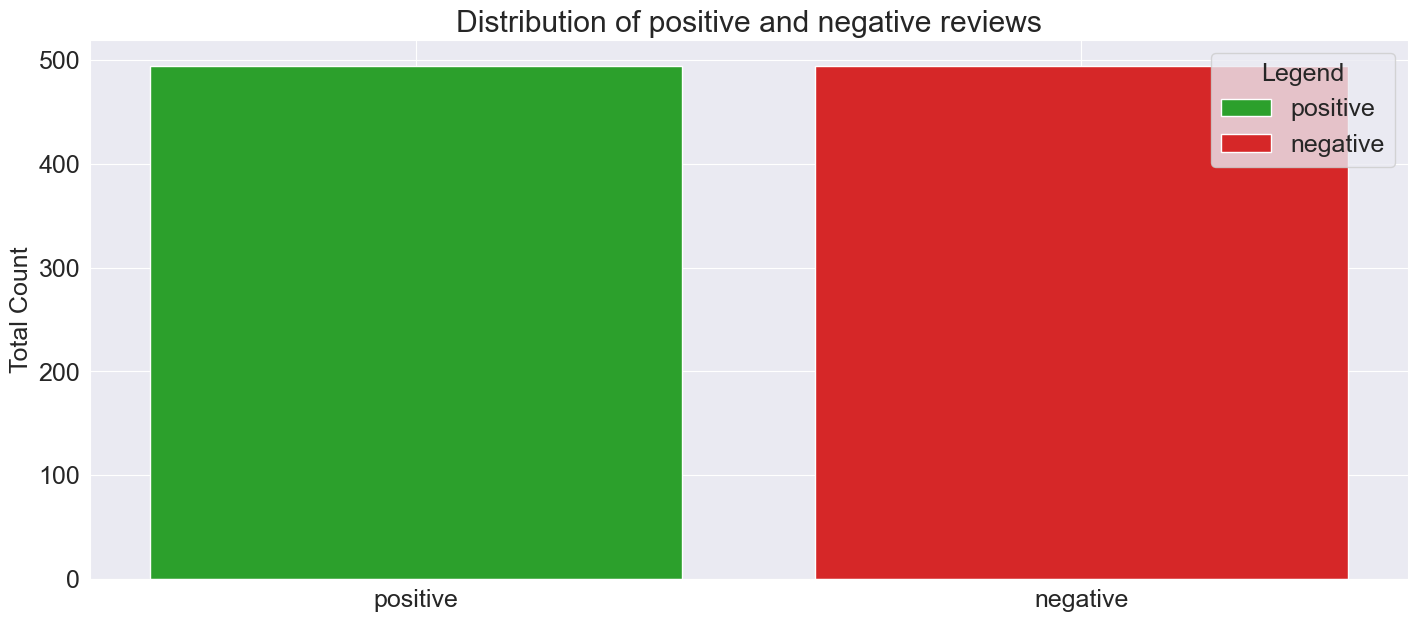

In [16]:
fig, ax = plt.subplots()

values = ['positive', 'negative']
counts = [data['value'].value_counts()[1], data['value'].value_counts()[0]]
bar_labels = ['positive', 'negative']
bar_colors = ['tab:green', 'tab:red']

ax.bar(values, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Total Count')
ax.set_title('Distribution of positive and negative reviews')
ax.legend(title='Legend')

plt.show()

## Analysis

The dataset contains roughly equal amounts of positive and negative reviews. This will help in keeping the model balanced.

Now let's see which words are the most common in both negative and positive reviews. To do this, we will create a new column called word_list. This column will split all words from the review column into a list so that we can easily count the occurrence of each word.

In [17]:
def review_to_word_list(review):
    word_list = review.split()
    return word_list

In [18]:
data['word_list'] = data['review'].apply(review_to_word_list)
data.head()

,review,value,sentence_length,word_count,word_list
0,wow loved place,1,15,3,"[wow, loved, place]"
1,crust good,0,10,2,"[crust, good]"
2,tasty texture nasty,0,19,3,"[tasty, texture, nasty]"
3,stopped late may bank holiday rick steve recom...,1,61,9,"[stopped, late, may, bank, holiday, rick, stev..."
4,selection menu great prices,1,27,4,"[selection, menu, great, prices]"


Now lets make separate dataframes for positive and negative reviews

In [19]:
data['value'] = data['value'].astype(int)
pos_reviews = data[data['value'] == 1]
neg_reviews = data[data['value'] == 0]

In [20]:
pos_reviews.head()

,review,value,sentence_length,word_count,word_list
0,wow loved place,1,15,3,"[wow, loved, place]"
3,stopped late may bank holiday rick steve recom...,1,61,9,"[stopped, late, may, bank, holiday, rick, stev..."
4,selection menu great prices,1,27,4,"[selection, menu, great, prices]"
8,fries great,1,11,2,"[fries, great]"
9,great touch,1,11,2,"[great, touch]"


Now we can analyze the common words for each of the new dataframes. First, let's count the words using Counter and most_common()

In [21]:
pos_words = [word for word_list in pos_reviews['word_list'] for word in word_list]
counter = Counter(pos_words)
common_pos_words = counter.most_common(10)

neg_words = [word for word_list in neg_reviews['word_list'] for word in word_list]
counter = Counter(neg_words)
common_neg_words = counter.most_common(10)

In [22]:
words = []
pos_freq = []
for word, count in common_pos_words:
    words.append(word)
    pos_freq.append(count)

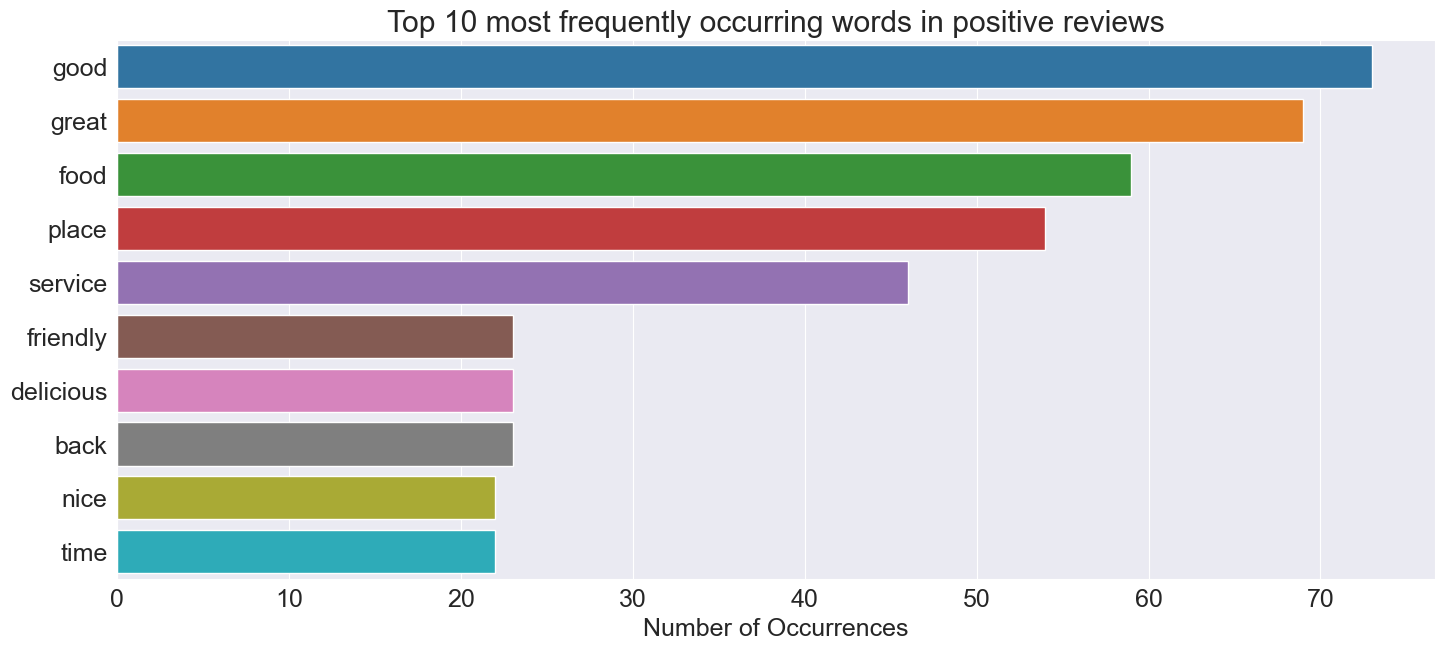

In [23]:
sns.barplot(x=pos_freq, y=words)
plt.title('Top 10 most frequently occurring words in positive reviews')
plt.xlabel('Number of Occurrences')
plt.show()

In [24]:
words = []
neg_freq = []
for word, count in common_neg_words:
    words.append(word)
    neg_freq.append(count)

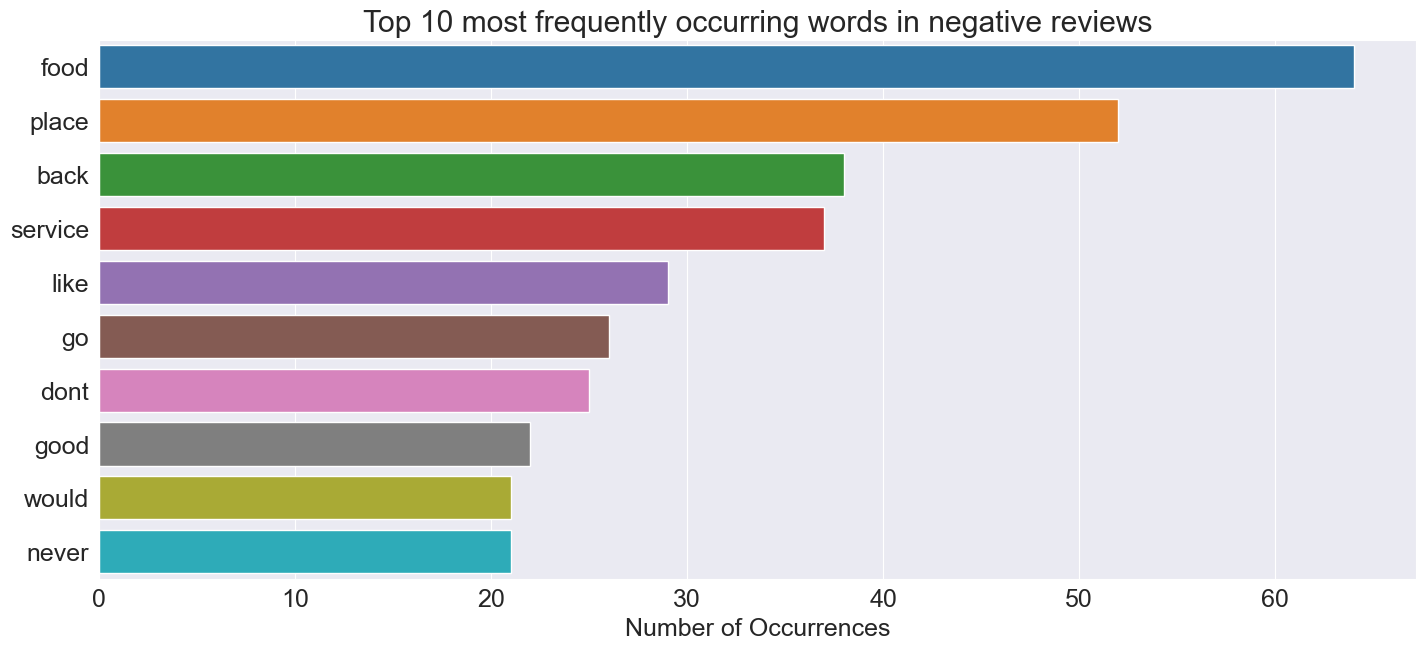

In [25]:
sns.barplot(x=neg_freq, y=words)
plt.title('Top 10 most frequently occurring words in negative reviews')
plt.xlabel('Number of Occurrences')
plt.show()

## Analysis

It appears that there is some overlap in the top ten words of positive and negative reviews. Notably, "food," "service," "back," and "place" are in both the negative and positive reviews. In fact, other than the word "back," there all in the top five most common words. If we struggle with accuracy of our model later on, it may be beneficial to treat them as stop words and remove them from the dataset. First though, I would like to explore some most common bi- and tri-grams.

To start, the n-grams, let's use CountVectorizer and then build a bar plot similar to the one we used for most common words.

In [26]:
cv_bi_pos = CountVectorizer(ngram_range=(2, 2))
cv_bi_neg = CountVectorizer(ngram_range=(2, 2))
cv_tri_pos = CountVectorizer(ngram_range=(3, 3))
cv_tri_neg = CountVectorizer(ngram_range=(3, 3))
bigrams_pos = cv_bi_pos.fit_transform(pos_reviews['review'])
trigrams_pos = cv_tri_pos.fit_transform(pos_reviews['review'])
bigrams_neg = cv_bi_neg.fit_transform(neg_reviews['review'])
trigrams_neg = cv_tri_neg.fit_transform(neg_reviews['review'])

We need to use separate CV's for each instance to ensure our index values match between the cv and its relevant fit_transform.

Now we can build dataframes out of these CV's from which we can build bar plots.

In [27]:
count_values = bigrams_pos.toarray().sum(axis=0)
bigrams_freq_pos = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv_bi_pos.vocabulary_.items()], reverse=True))
bigrams_freq_pos.columns = ['frequency', 'bigrams']

In [28]:
count_values = trigrams_pos.toarray().sum(axis=0)
trigrams_freq_pos = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv_tri_pos.vocabulary_.items()], reverse=True))
trigrams_freq_pos.columns = ['frequency', 'trigrams']

In [29]:
count_values = bigrams_neg.toarray().sum(axis=0)
bigrams_freq_neg = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv_bi_neg.vocabulary_.items()], reverse=True))
bigrams_freq_neg.columns = ['frequency', 'bigrams']

In [30]:
count_values = trigrams_neg.toarray().sum(axis=0)
trigrams_freq_neg = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv_tri_neg.vocabulary_.items()], reverse=True))
trigrams_freq_neg.columns = ['frequency', 'trigrams']

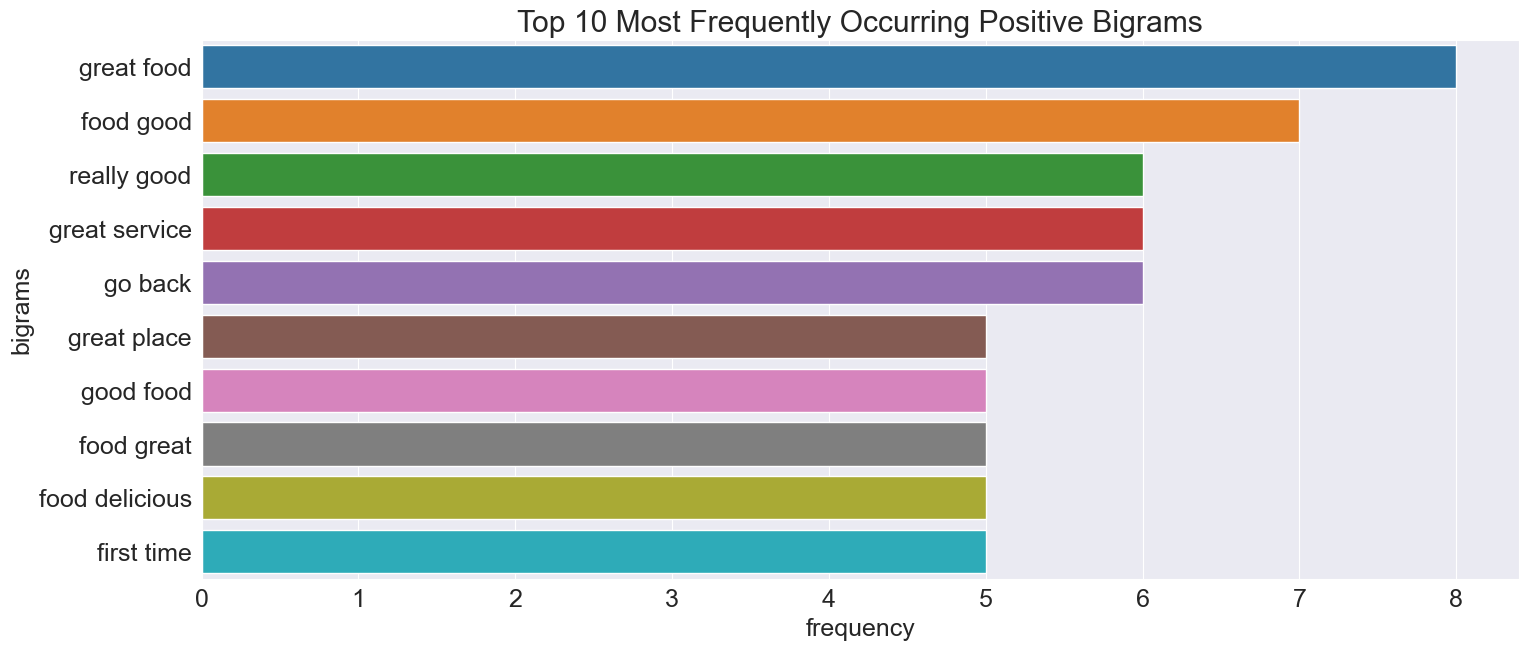

In [31]:
#positive bi-grams bar plot
sns.barplot(x=bigrams_freq_pos['frequency'][:10], y=bigrams_freq_pos['bigrams'][:10])
plt.title('Top 10 Most Frequently Occurring Positive Bigrams')
plt.show()

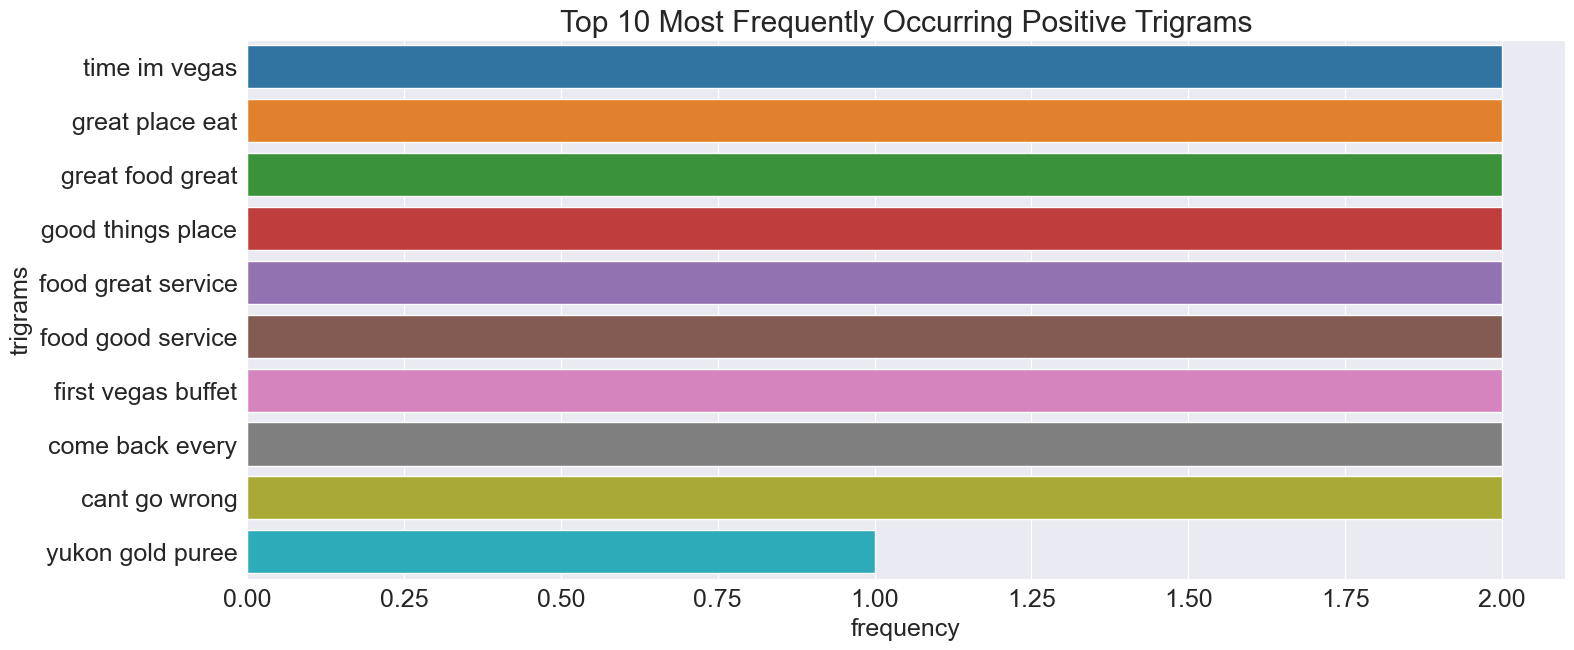

In [32]:
#positive tri-grams bar plot
sns.barplot(x=trigrams_freq_pos['frequency'][:10], y=trigrams_freq_pos['trigrams'][:10])
plt.title('Top 10 Most Frequently Occurring Positive Trigrams')
plt.show()

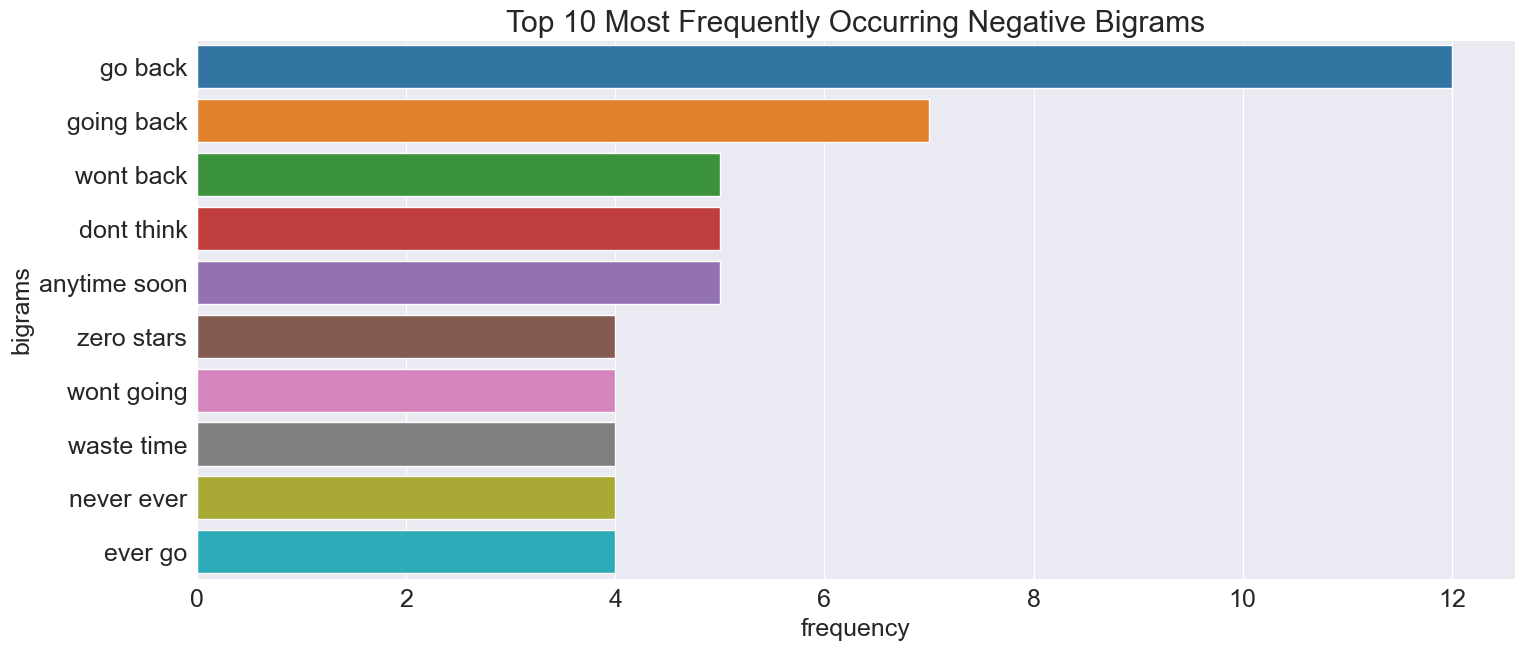

In [33]:
#negative bi-grams bar plot
sns.barplot(x=bigrams_freq_neg['frequency'][:10], y=bigrams_freq_neg['bigrams'][:10])
plt.title('Top 10 Most Frequently Occurring Negative Bigrams')
plt.show()

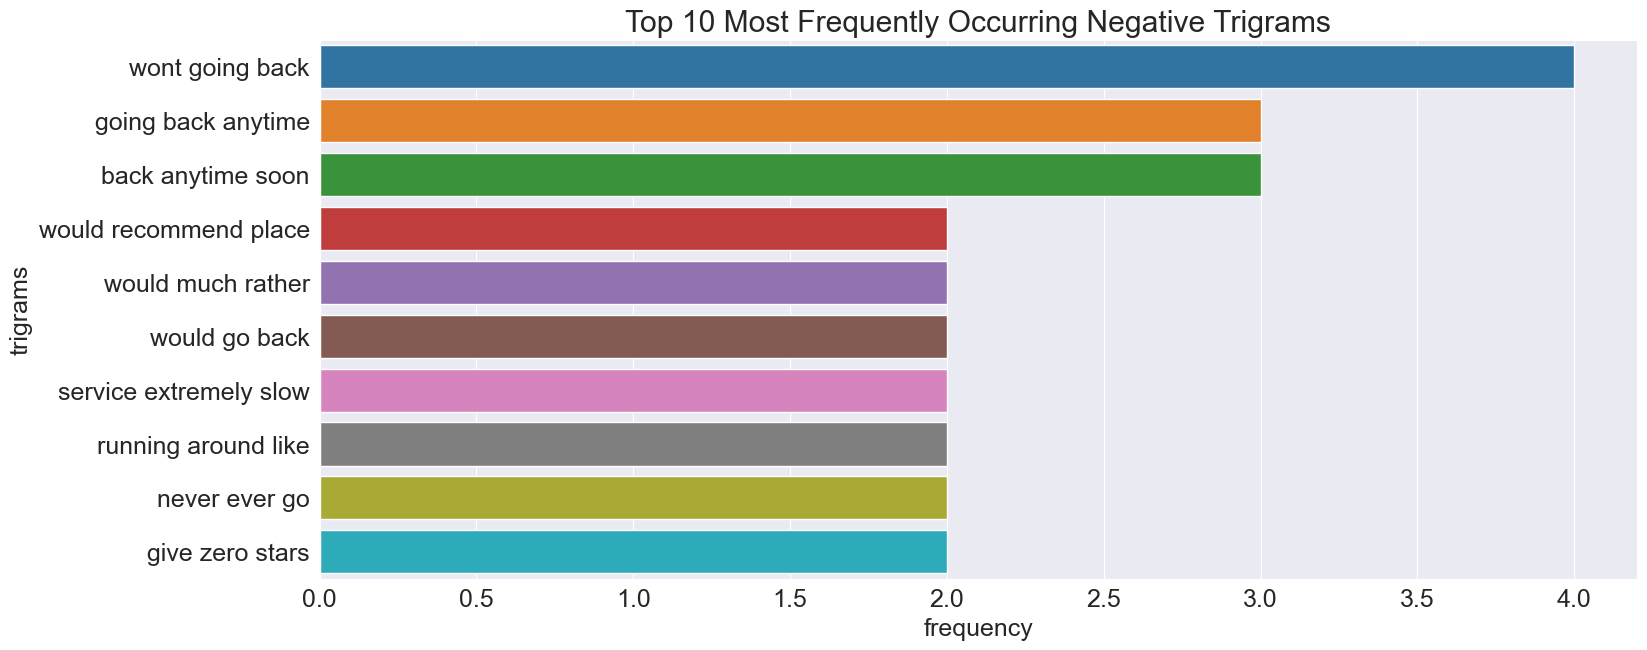

In [34]:
#negative tri-grams bar plot
sns.barplot(x=trigrams_freq_neg['frequency'][:10], y=trigrams_freq_neg['trigrams'][:10])
plt.title('Top 10 Most Frequently Occurring Negative Trigrams')
plt.show()

## Analysis

"Go back" appears in both the negative and positive bi-grams. If we recall, "back" was also a top ten word for both positive and negative reviews, and this new common occurrence in the bi-grams gives more credence to the idea of treating back as a stop word to see how that would affect the model's accuracy. However, "go back" appears 12 times in the negative bi-grams, and it is the most common bi-gram overall, while in the positive bi-grams, "go back" only appears 6 times. There does not appear to be any overlap in tri-grams between negative and positive reviews, and no obvious candidates jump out for causing poor accuracy in the model.

Next, let's examine the distribution of the overall word count of both positive and negative reviews.

In [35]:
pos_reviews.head()

,review,value,sentence_length,word_count,word_list
0,wow loved place,1,15,3,"[wow, loved, place]"
3,stopped late may bank holiday rick steve recom...,1,61,9,"[stopped, late, may, bank, holiday, rick, stev..."
4,selection menu great prices,1,27,4,"[selection, menu, great, prices]"
8,fries great,1,11,2,"[fries, great]"
9,great touch,1,11,2,"[great, touch]"


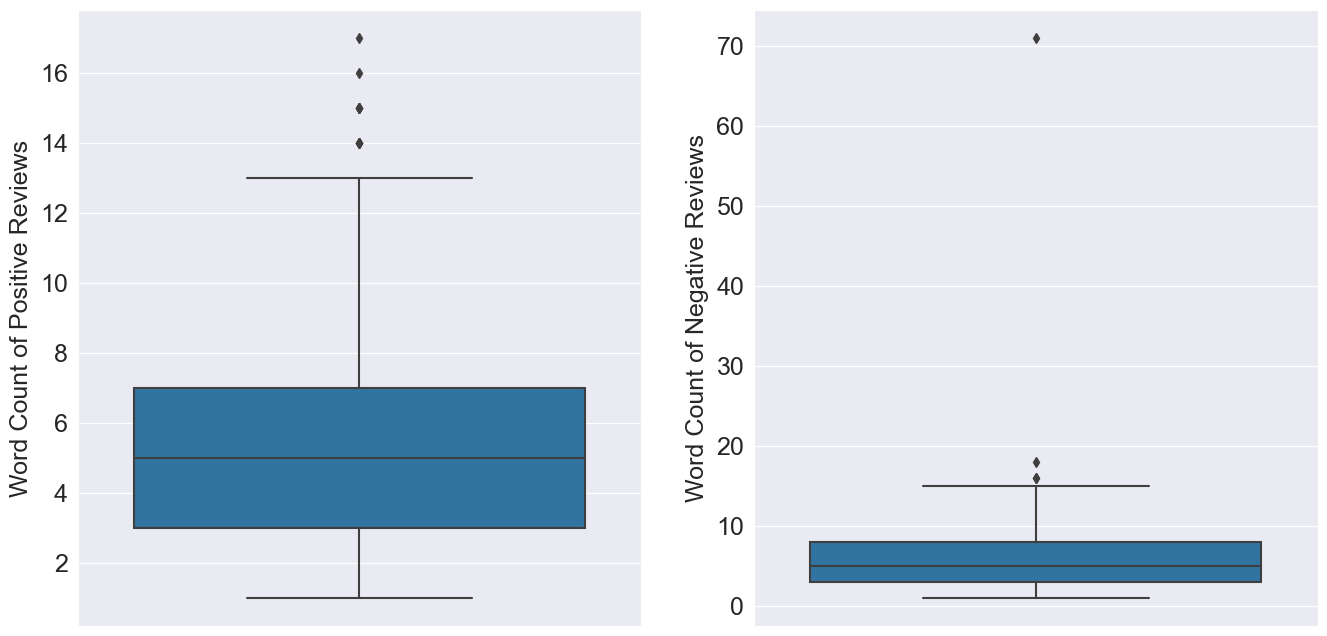

In [36]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.boxplot(y=pos_reviews['word_count'])
plt.ylabel('Word Count of Positive Reviews', labelpad=5)
plt.subplot(1,2,2)
sns.boxplot(y=neg_reviews['word_count'])
plt.ylabel('Word Count of Negative Reviews', labelpad=5)
plt.show()

### Analysis

From the graph we can see that most of the reviews, both positive and negative, have less than ten words in them. Both sets of reviews have some outliers in the upperbounds, with negative reviews having one standout review with over 70 words. I don't think this is telling us anything too shocking, and I am comfortable moving on to the modeling phase.

# EDA Wrapup

We learned that our dataset is evenly distributed between positive and negative reviews. We also learned that positive and negative reviews have some similarities in their word makeup. These similar words may be good candidates for removal if we run into any issues with accuracy of our model. We also learned the word count distribution between positive and negative reviews is similar, with one notable outlier on the negative reviews.

# Modeling

Now that we have completed our EDA, let's begin modeling. We will no longer need to use the segregated positive and negative review dataframes, as we can now just use the original dataframe from which they were built.

First, let's vectorize our data so that the model can understand it. Then we will split our train and test data.

In [37]:
cv1 = CountVectorizer()
X = cv1.fit_transform(data['review'])
y = data['value']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=80
)

Now we can introduce our model, which is a Multinomial Naive Bayes model. This dataset is dealing with word frequencies as features, as such a Multinomial Naive Bayes model is well suited for the task, and it is why I chose it.

In [39]:
model = MultinomialNB().fit(X_train, y_train)

In [40]:
model.predict_proba(X_test)[:,1]

array([1.21706872e-03, 9.43293998e-01, 9.99213985e-01, 3.49765208e-01,
       6.13387770e-01, 8.01497841e-01, 3.28807259e-01, 5.03609264e-01,
       6.16457619e-01, 8.44863165e-01, 5.14023822e-01, 9.94273285e-01,
       5.14023822e-01, 1.08536398e-01, 8.57431437e-01, 3.63827867e-01,
       7.93737538e-01, 1.77640773e-01, 1.61421155e-01, 1.75703651e-02,
       9.46895696e-01, 1.19779653e-01, 1.50223448e-01, 5.14023822e-01,
       3.36442554e-01, 9.43895459e-01, 3.52916180e-01, 2.42979629e-02,
       8.42824750e-01, 2.56945733e-01, 2.51011332e-01, 2.97082123e-02,
       8.41823677e-03, 2.27267404e-01, 9.28028691e-01, 8.11606056e-05,
       5.33550007e-03, 1.39502787e-01, 5.76536855e-01, 9.43895459e-01,
       7.71735912e-02, 2.78212558e-02, 4.35144621e-01, 8.13319222e-01,
       9.99898851e-01, 8.24600664e-01, 4.51567865e-01, 8.43501166e-01,
       4.06446673e-01, 1.80323041e-01, 3.02217273e-01, 1.39814883e-01,
       8.99726556e-01, 9.82450609e-01, 7.75561124e-02, 2.30817416e-01,
      

In [41]:
model.score(X_test, y_test)

0.8080808080808081

Our accuracy score for the test dataset is ~ 80.8%.

But let's test how well our model fit to our training dataset. We will do this by running the same model.score() on the X_trina, y_train and comparing the score to the X_test, y_test.

In [42]:
model.score(X_train, y_train)

0.9532237673830595

# Model Analysis and Conclusion

Our model's accuracy on the training dataset is ~ 95.32%. This is significantly higher than our model's accuracy on the test dataset. This suggests that our model is overfitted to our training set. Ideally, we would like the  scores to be similar to avoid overfitting. Possible reasons our score on the test data set is not higher could be the fact that both the negative and positive reviews share many common words, and that we are dealing with a relatively small dataset of only about 1000 entries. However, for our purposes this accuracy and fitting is acceptable since the reviews being flagged will be read by our marketing team anyway.

# User testing area below.

To test, assign 'user_input' the string of text you wish to test. To do this, replace the phrase "Insert text here" without removing the quotation marks.

## **'array([0])' = Negative**

## **'array([1])' = Positive**

If the output of the statement is 'array([0])' that means the model is predicting that the user's text is negative.

Conversely, if the output is 'array([1])' then the model is predicting the user's provided text is positive.

In [43]:
user_input = "Insert text here"
str_want = pd.DataFrame([user_input])
x_want = cv1.transform(str_want[0])
model.predict(x_want)

array([0])